## Modelli di Approssimazione e Minimi Quadrati
Come visto nel capitolo precedente, per sviluppare un Metodo di Approssimazione abbiamo bisogno prima di tutto di un set di dati. In tal senso, riconosciamo due tipologie principali di variabili:

- Le variabili **indipendenti**, o variabili di **input**, che rappresentano un valore noto, come il giorno nell'esempio precedente. Queste sono spesso indicate con il simbolo $x$.
- Le variabili **dipendenti**, o variabili di **output**, che rappresentano il valore che vogliamo prevedere. Queste sono spesso indicate con il simbolo $y$.

> Un **set di dati** è quindi una collezione di coppie di valori $\{ (x_1, y_1), (x_2, y_2), \dots, (x_n, y_n) \}$, tra loro associati.

Come già accennato, gli algoritmi di approssimazione si basano su due assunzioni principali:

1. I dati seguono l'andamento di una **curva** relativamente complessa, ma con un pattern chiaramente riconoscibile.
2. I dati **NON** sono disposti in maniera precisa lungo la curva, ma mostrano un comportamento casuale: sono affetti da *rumore*.

Matematicamente, possiamo rappresentare la prima assunzione dicendo:

> Esiste una funzione $f(x)$ tale per cui $y \approx f(x)$, dove l'errore tra la previsione $f(x)$ e i veri dati $y$ misurati è dovuta al solo rumore.

La seconda ipotesi, invece, si riformula come:

> Esiste una variabile casuale $e$ tale che $y = f(x) + e$ per ogni $x$.

```{note}
Nel seguito, assumeremo sempre che la variabile casuale $e$ abbia distribuzione normale. In particolare, se $y$ rappresenta un vettore di dimensione `(n,)`, allora assumeremo che $e$ sia generata da una funzione del tipo: `np.random.randn(n)`.
```

Date le due assunzioni precedenti, un *metodo di approssimazione* è un qualunque algoritmo che, fissato un modello $f_\theta(x)$ dipendente da un'insieme di parametri $\theta$, calcola il valore dei parametri $\theta$ tali che $f_\theta(x)$ sia il più possibile vicina a $f(x)$.

## Il problema test
Lavorare con i dati reali come quelli descritti nella precedente sezione comporta una serie di problemi e difficoltà che, in un primo momento, è bene cercare di eliminare.

Per questo motivo, come si è soliti fare, andiamo a costruire un problema test, dove la soluzione **esatta** è nota per definizione, e dove abbiamo un controllo più preciso sui dati.

Per quanto detto precedentemente, la creazione di un problema test richiede di soddisfare le due assunzioni che abbiamo dichiarato, e quindi bisogna:

1. Specificare una funzione $f(x)$.
2. Generare del rumore Gaussiano $e$.

Per questo corso, siamo interessati a modelli di approssimazione **polinomiali**, in cui cioè la funzione $f(x)$ si assume essere un polinomio nella variabile $x$ di grado $d$, ovvero:

$$
f(x) = a_0 + a_1 x + a_2 x^2 + \dots + a_d x^d = \sum_{k=0}^d a_k x^k.
$$

```{note}
Dalla scrittura sopra si osserva una proprietà importante dei polinomi: una funzione polinomiale di grado $d$ dipende in maniera **unica** dai coefficienti $a_0, a_1, \dots, a_d$ che moltiplicano le potenze di $x$.
```

Nel seguito raccogliamo per semplicità i coefficienti $a_0, a_1, \dots, a_d$ in un unico vettore $\alpha$, di shape `(d+1, )`.

In [ ]:
import numpy as np

# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un valore x, e ritorna il valore del rispettivo polinomio
def f(x, alpha):
    d = alpha.shape[0] - 1 # abbiamo detto che la shape di alpha è (d+1, )

    y = 0
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

Definiamo ora un vettore $\alpha_{true}$ di esempio, che rappresenta il **vettore dei parametri reali**, su cui costruiremo il nostro problema di test.

In [2]:
# Definiamo alpha_true = (1, 1, ..., 1) 
# NOTA: si può scegliere un QUALUNQUE vettore alpha_true. Quello indicato è solo un esempio.
d = 3 # grado del polinomio
alpha_true = np.ones((d+1,))

# Scegliamo un valore di x
x = 3
y = f(x, alpha_true)
print(f"(x = {x}, y = {y})")

(x = 3, y = 40.0)


A questo punto, costruiamo un set $x_1, \dots, x_n$ di dati di *input* **sintetici**. Per farlo, prendiamo $n$ valori equidistribuiti nell'intervallo $[0, 1]$.

```{nota}
Come già detto precedentemente, la scelta dei dati $x_1, \dots, x_n$ (come del vettore dei parametri $\alpha$) è **libera** e serve solo a scopo esemplificativo per costruire un problema test di cui si conosce la soluzione esatta.
```

In [3]:
# Numero di dati
n = 15

# Definiamo gli x_i
x = np.linspace(0, 1, n)

A questo punto, per ogni $i = 1, \dots n$, costruiamo i valori di output:

$$
y_i = f(x_i, \alpha) + e_i = \sum_{k=0}^n a_k x_i^k + e_i,
$$

dove $e_i$ è del rumore gaussiano estratto con la funzione `np.random.normal(loc=0, scale=sigma, size=(1, ))`, con deviazione standard `sigma = 0.1`.

In [4]:
# Definiamo la deviazione standard del rumore
sigma = 0.1

# Generiamo il rumore
e = np.random.normal(loc=0, scale=sigma, size=(n, ))

# Inizializziamo y
y = np.zeros_like(x)

for i in range(n):
    y[i] = f(x[i], alpha_true) + e[i]

Così che abbiamo a disposizione i nostri dati $\{ (x_1, y_1), \dots, (x_n, y_n) \}$ dei quali sappiamo, **per costruzione**, che $\alpha_{true} = (1, 1, \dots, 1)$ è la soluzione esatta. 

La definizione del modello per l'approssimazione di tale funzione (ovvero, quella che avevamo chiamato precedentemente $f_\theta(x)$), è in questo caso particolarmente semplice: basta considerare una funzione polinomiale

$$
f(x, \alpha) = \sum_{k=0}^d a_k x^k,
$$

e si cerca il valore di $\alpha$ tale per cui $f(x, \alpha) \approx f(x, \alpha_{true})$.

```{warning}
Si potrebbe pensare che risolvere questo task sia **banale**, ma così non è. Infatti, si osservi che i valori esatti di $f(x, \alpha_{true})$ non sono noti, poiché noi stiamo assumendo di avere soltando accesso ad una versione *rumorosa* di $f(x, \alpha_{true})$, rappresentata dagli $y_i$. Di conseguenza, recuperare il valore corretto di $\alpha$ è un compito tutt'altro che semplice!
```

Come di consueto per la creazione di problemi test, assumiamo ora di **NON** conoscere la soluzione esatta $\alpha_{true}$, e andiamo a costruire un'algoritmo che va a stimare dei parametri $\alpha$. Possiamo quindi valutare la qualità della ricostruzione andando a confrontare i parametri $\alpha$ calcolati con la soluzione esatta $\alpha_{true}$. La qualità dell'algoritmo di ricostruzione verrà infatti valutata dall'errore relativo:

$$
E(\alpha, \alpha_{true}) = \frac{|| \alpha - \alpha_{true} ||}{|| \alpha_{true} ||}.
$$

Per farci un'idea del problema che stiamo per andare a risolvere, andiamo a rappresentare su un grafico i dati che abbiamo generato, e la curva "vera". Per semplicità, andiamo a ri-definire la funzione `f(x, alpha)` in maniera tale che prenda come input un numpy array `x` e ne ritorni il valore del polinomio descritto precedentemente, elemento per elemento.

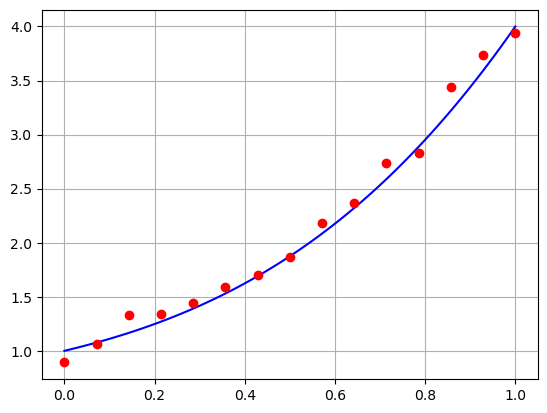

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un vettore x di lunghezza n, e ritorna il valore del rispettivo polinomio calcolato su x elemento per elemento
def f(x, alpha):
    d = alpha.shape[0] - 1 # abbiamo detto che la shape di alpha è (d+1, )

    y = np.zeros_like(x) # Questa è l'unica riga che dobbiamo cambiare rispetto a prima!
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

# Andiamo a rappresentare la curva *vera* in [0, 1]
xx = np.linspace(0, 1, 100)
yy = f(xx, alpha_true)

plt.plot(xx, yy, 'b')
plt.plot(x, y, 'ro')
plt.grid()
plt.show()

## Approssimazione ai minimi quadrati
Come abbiamo detto, come modello per l'approssimazione andiamo a scegliere:

$$
f_\theta(x, \alpha) = \sum_{k=0}^d a_k x^k,
$$

dove $d$ (il grado del polinomio), viene scelto dall'utente e **NON** deve necessariamente essere uguale a quello utilizzato durante la creazione del problema test (che assumiamo di non conoscere).

Prima di tutto notiamo che la definizione di $f_\theta(x, \alpha)$ può essere modificata osservando che, se definiamo:

$$
x^{(d)} := [ x^0 x^1 \dots x^d ] \in \mathbb{R}^{d+1}
$$

come il vettore di lunghezza $d+1$ il cui $k$-esimo elemento è $x^k$, allora:

$$
f_\theta(x, \alpha) = \alpha^T x^{(d)}.
$$

Come detto precedentemente, il nostro scopo è identificare quei parametri tali per cui $f_\theta(x, \alpha)$ approssimi $y$ (a meno di rumore) sui dati. Il modo più naturale per ottenere questo risultato è quello di minimizzare l'errore medio di predizione del modello $f_\theta(x, \alpha)$ (errore misurato, per motivi statistici, come distanza quadratica):

$$
\min_{\alpha} \sum_{i=1}^n (f_\theta(x_i, \alpha) - y_i)^2 = \\
\min_{\alpha} \sum_{i=1}^n (\alpha^T x_i^{(d)} - y_i)^2.
$$

Notare che, definendo:

$$
X = \begin{bmatrix} {x_1^{(d)}}^T \\ {x_2^{(d)}}^T \\ \vdots \\ {x_n^{(d)}}^T  \end{bmatrix} = \begin{bmatrix} x_1^0 & x_1^1 & \dots & x_1^d \\ x_2^0 & x_2^1 & \dots & x_2^d \\ \vdots & \vdots & \ddots & \vdots \\ x_n^0 & x_n^1 & \dots & x_n^d  \end{bmatrix} \in \mathbb{R}^{n \times d},
$$

la matrice che ha per righe i dati, spesso chiamata **matrice di Vandermonde** di grado $d$ associata ad $\{ x_1, x_2, \dots, x_n \}$, la formula sopra è equivalente a:

$$
\min_{\alpha} || X\alpha - y ||_2^2,
$$

dove abbiamo indicato con $y = [y_1, \dots, y_n]$ il vettore che ha per elementi i dati. 

Si osservi che il problema appena ottenuto non è altro che un *semplice* problema ai minimi quadrati, già affrontato a lezione, in cui la matrice è rappresentata dalla matrice di Vandermonde di grado $d$ associata ai dati $\{ x_1, \dots, x_n \}$, mentre il termine noto è rappresentato dai dati (**rumorosi**) $\{ y_1, \dots, y_n \}$. 

Andiamo a costruire queste quantità in Python.

```{note}
Il vettore `y` che abbiamo già costruito durante la costruzione del problema test, rappresenta lo stesso vettore $y$ della formulazione matematica ai minimi quadrati.
```

In [6]:
def vandermonde(x, d):
    r"""
    Preso in input un numpy array "x" di lunghezza (n, ) contentente i dati, e un valore intero "d" rappresentante il grado del polinomio, 
    costruisce e ritorna la matrice di vandermonde X di grado d, associata a x.

    Parameters:
    x (ndarray): Il vettore dei dati di input.
    d (int): Il grado massimo del polinomio.

    Returns:
    X (ndarray): La matrice di Vandermonde di grado "d", associata ad x.
    """
    n = x.shape[0]
    
    # Inizializzo la matrice di Vandermonde con shape (n, d+1)
    X = np.zeros((n, d+1))
    
    # Costruisco la matrice di Vandermonde
    for i in range(d+1):
        X[:, i] = x ** i
    return X

# Definiamo la matrice di Vandermonde tramite la funzione appena definita con grado d = 5
d = 5
X = vandermonde(x, d)

Ora, dato un vettore $\alpha$ di lunghezza $d+1$, possiamo calcolare il valore del **residuo**, definito come:

$$
r(\alpha) := || X\alpha - y ||_2^2,
$$

che misura la discrepanza tra la previsione del modello di approssimazione (cioè $X\alpha$), e i dati misurati ($y$). Risolvere il problema ai minimi quadrati corrisponde a minimizzare questa quantità. 

In [7]:
def residuo(X, y, alpha):
    r = np.linalg.norm(X @ alpha - y) ** 2
    return r

# Testiamo la funzione con un alpha generato casualmente
alpha = np.random.randn(d+1)
print(f"Residuo: {residuo(X, y, alpha)}.")

Residuo: 39.09694224233372.


## Risoluzione mediante Equazioni Normali
Dobbiamo quindi trovare il valore di $\alpha$ che risolva:

$$
\min_{\alpha} || X\alpha - y ||_2^2.
$$

Avete già visto a lezione che questo può essere fatto risolvendo le **equazioni normali** associate a tale problema, ovvero:

$$
X^T X \alpha = X^T y.
$$

Questo può essere fatto tramite:

* Decomposizione di Cholesky;
* Decomposizione ai Valori Singolari (SVD);

Vediamo i due metodi nel dettaglio.

### Risoluzione tramite fattorizzazione LU

Siccome $X$ ha dimensione $(n, d+1)$, e siccome (auspicabilmente), $n \gg d+1$, allora il rango di $X$ è massimo se e solo se è uguale a $d+1$. Verifichiamo che questo succede.

In [8]:
# Calcoliamo il rango della matrice di Vandermonde X
rk_X = np.linalg.matrix_rank(X)
print(f"Il rango di X è massimo? {rk_X == (d+1)}.")

Il rango di X è massimo? True.


Possiamo quindi applicare la fattorizzazione LU, 

$$
X^T X = L U.
$$

Il sistema dell equazioni normali può quindi essere risolto tramite il metodo della sostituzione all'Avanti e all'Indietro, ovvero risolvendo i due sistemi (triangolari):

$$
\begin{cases}
    L z = X^T y \\
    U \alpha = z.
\end{cases}
$$

In Python:

In [16]:
#Calcoliamo la matrice dei coefficienti delle equazioni normali
XtX=X.T@X

# Calcoliamo il termine noto X^T y
Xty = X.T @ y

# Troviamo z
alpha_eqn= np.linalg.solve(XtX, Xty)


Una volta trovata la nostra soluzione `alpha_sol`, visualizziamo su grafico come viene la curva calcolata tramite questo algoritmo di approssimazione rispetto ai dati che abbiamo a disposizione e rispetto alla curva vera. 

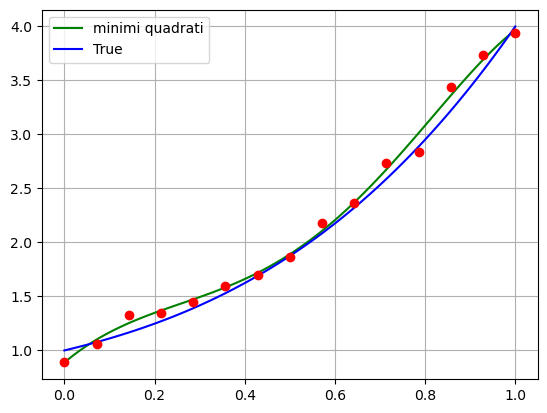

In [17]:
# Rappresentiamo la curva *approssimata* in [0, 1]
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
yy_eqn = f(xx, alpha_eqn)

plt.plot(xx, yy_eqn, 'g')
plt.plot(xx, yy_true, 'b')
plt.plot(x, y, 'ro')
plt.legend(["minimi quadrati", "True"])
plt.grid()
plt.show()

E' abbastanza chiaro che la curva ricostruita non riesce ad approssimare correttamente i dati. Prima di discutere le ragioni e le possibili soluzioni di questo comportamento, vediamo come risolvere in maniera alternativa il problema ai minimi quadrati tramite decomposizione a valori singolari.

### Risoluzione tramite SVD
Consideriamo la decomposizione a Valori Singolari (SVD) della matrice $X$:

$$
X = U \Sigma V^T,
$$

dove $U \in \mathbb{R}^{n \times n}$ e $V \in \mathbb{R}^{(d+1) \times (d+1)}$ sono matrici ortogonali, mentre $\Sigma \in \mathbb{R}^{n \times (d+1)}$ è una matrice diagonale i cui elementi sulla diagonale sono i valori singolari di $X$, in ordine decrescente.

In Python, è possibile calcolare la decomposizione SVD di $X$ tramite il comando `np.linalg.svd(X)`. Questa funzione ritorna tre `ndarray`: `U`, `s` e `VT`, dove `U` e `VT` rappresentano le matrici $U$ e $V^T$, rispettivamente, mentre `s` è un vettore che rappresenta la diagonale di $\Sigma$, ovvero i valori singolari della matrice $X$, in ordine decrescente.

In [18]:
# Calcoliamo la SVD di X
U, s, VT = np.linalg.svd(X)

# Costruiamo la matrice Sigma esplicitamente (per controllare che la SVD sia stata 
# svolta correttamente)
Sigma = np.zeros((n, d+1))
for i in range(d+1):
    Sigma[i, i] = s[i]

# Calcoliamo || X - U * Sigma * VT ||
print(f"|| X - U Sigma V^T || = {np.linalg.norm(X - U @ Sigma @ VT)}")

|| X - U Sigma V^T || = 2.4905065272728362e-15


Ricordando che le matrici $U$ e $V$ sono ortognali, le equazioni normali diventano:

$$
X^T X \alpha = X^T y \iff V \Sigma^2 V^T \alpha = V \Sigma U^T y \iff \Sigma^2 V^T \alpha = \Sigma U^T y
$$

La cui soluzione esplicita è:

$$
    \alpha = \sum_{i=1}^{d+1} \frac{u_i^T y}{\sigma_i} v_i. 
$$

Questa operazione può semplicemente essere implementata in Python come:

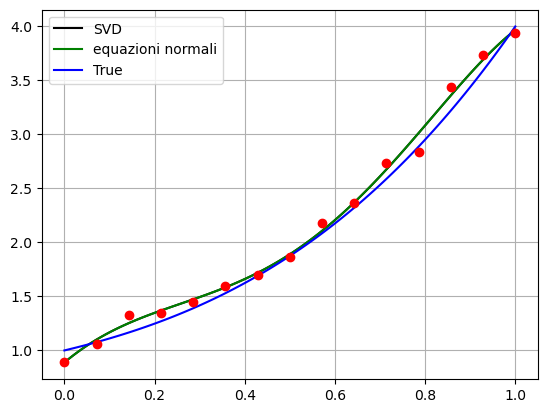

In [19]:
# Inizializzazione di alpha
alpha_svd = np.zeros((d+1, ))

# Aggiornamento
for i in range(d+1):
    alpha_svd = alpha_svd + (U[:, i].T @ y) / s[i] * VT[i, :]

# Rappresentiamo tutte le soluzioni su grafico
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
yy_chol = f(xx, alpha_eqn)
yy_svd = f(xx, alpha_svd)

plt.plot(xx, yy_svd, 'k')
plt.plot(xx, yy_eqn, 'g')
plt.plot(xx, yy_true, 'b')
plt.plot(x, y, 'ro')
plt.legend(["SVD", "equazioni normali", "True"])
plt.grid()
plt.show()

Le soluzioni $\alpha_{chol}$ e $\alpha_{SVD}$ sono, come ci si aspetta, identiche, poiché soluzioni dello stesso problema dei minimi quadrati, che ha soluzione unica.

> **Esercizio:** Prova a ri-eseguire lo script precedente modificando:
> - il numero $n$ dei dati,
> - il grado del polinomio che genera il problema test,
> - la quantità di rumore aggiunto sui dati,
> - il grado del polinomio del modello approssimante.
> 
> Cosa osservi, riguardo al comportamento del polinomio approssimante risultante?